In [32]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [33]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [34]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [35]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [36]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [37]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [38]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [39]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.02534504 1.03586708]
The function value of pqbest:		1.453055929867407
Algorithm running time:			5.265623092651367 s


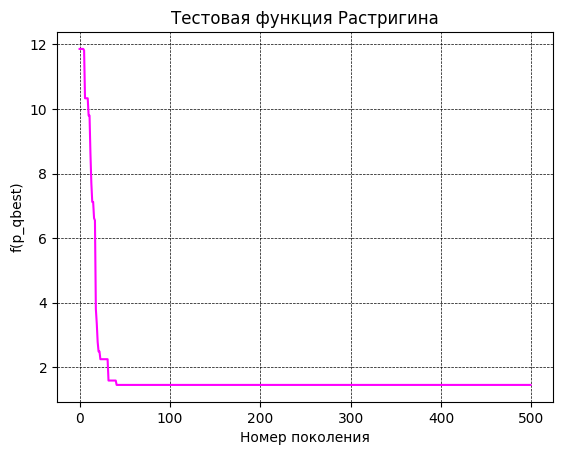

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 1.96488317 -0.99996946]
The function value of pqbest:		5.103141316283837
Algorithm running time:			0.07815265655517578 s


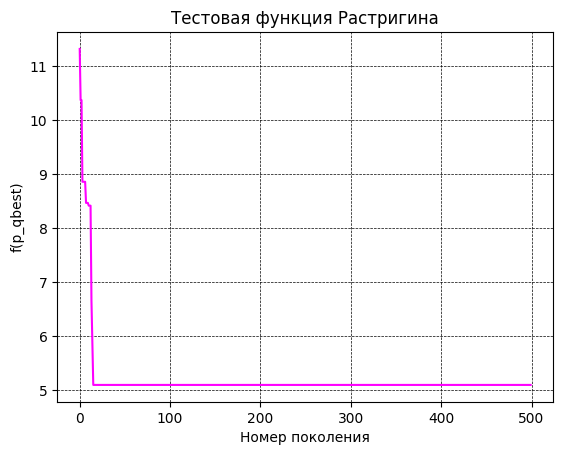

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.98253997  0.99229652]
The function value of pqbest:		2.021864031207862
Algorithm running time:			0.07785820960998535 s


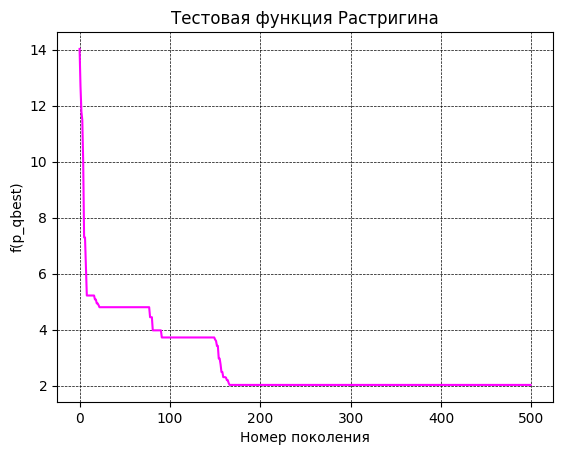

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[1.11827467 0.97767991]
The function value of pqbest:		4.941108016488499
Algorithm running time:			0.09374761581420898 s


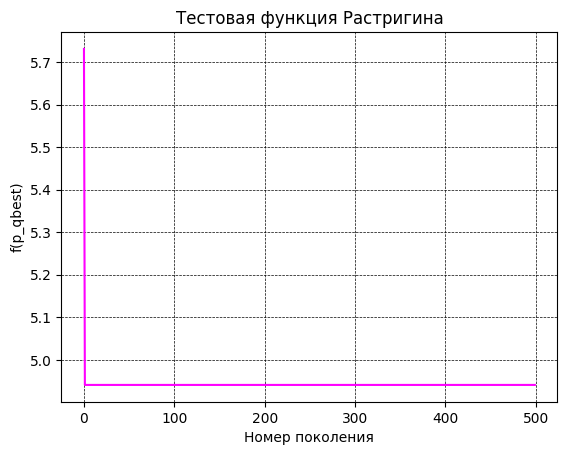

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.07516738 0.01911332]
The function value of pqbest:		1.1727541397808672
Algorithm running time:			0.07060813903808594 s


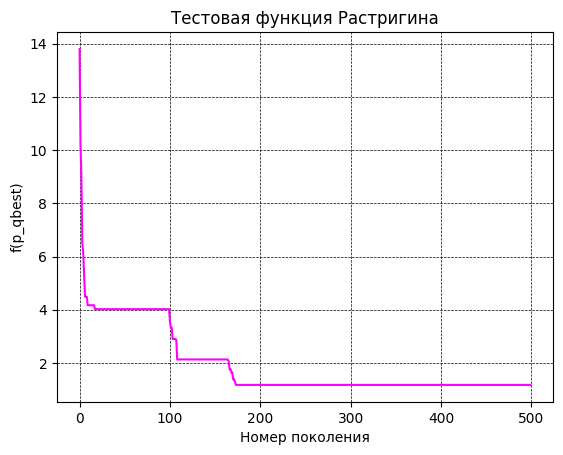

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 1.07849007 -0.01223906]
The function value of pqbest:		2.384467620913881
Algorithm running time:			0.07587409019470215 s


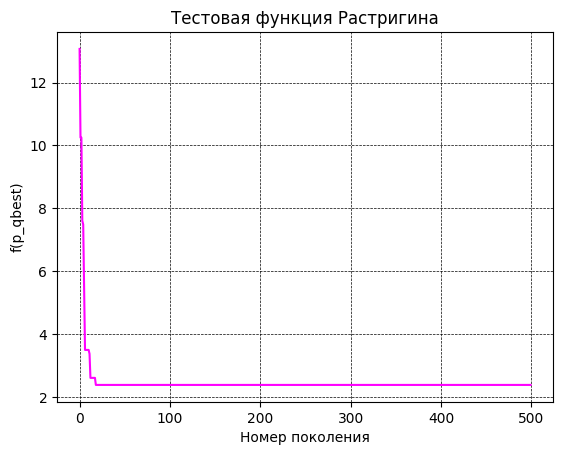

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-1.00518178  0.04695204]
The function value of pqbest:		1.4498974721271338
Algorithm running time:			0.1103966236114502 s


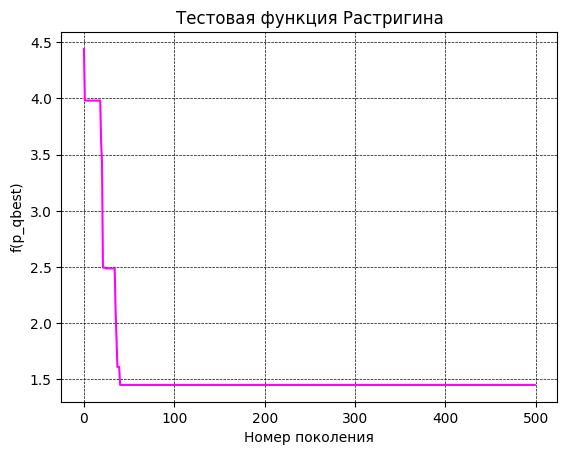

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.00316591 1.03283881]
The function value of pqbest:		1.2808554089175246
Algorithm running time:			0.07812666893005371 s


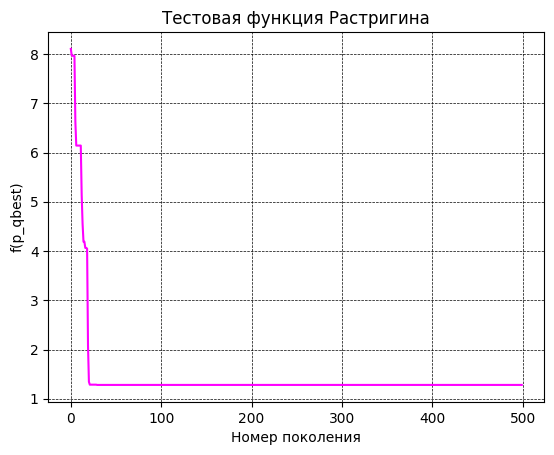

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.00311804 -0.86619664]
The function value of pqbest:		4.08289561339566
Algorithm running time:			0.07201933860778809 s


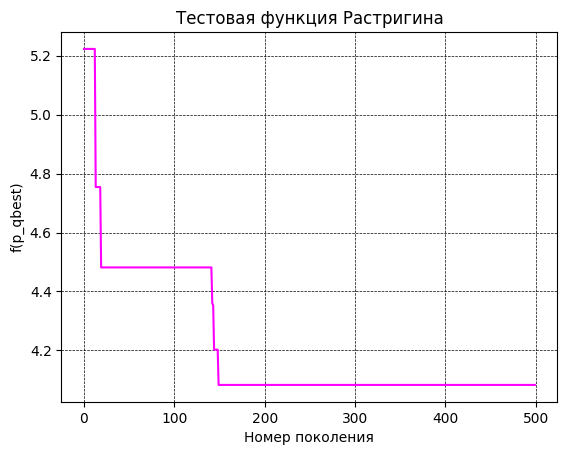

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.99015463 -0.01586036]
The function value of pqbest:		1.049398183455736
Algorithm running time:			0.07197356224060059 s


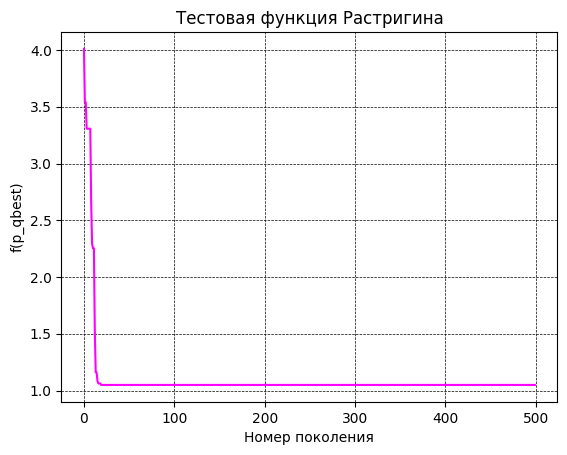

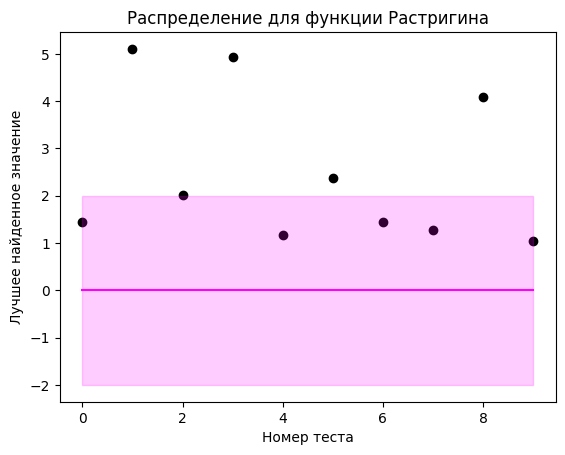

In [40]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [41]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [42]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.23993883 -0.10118653]
The function value of pqbest:		1.8981596419292401
Algorithm running time:			3.588432550430298 s


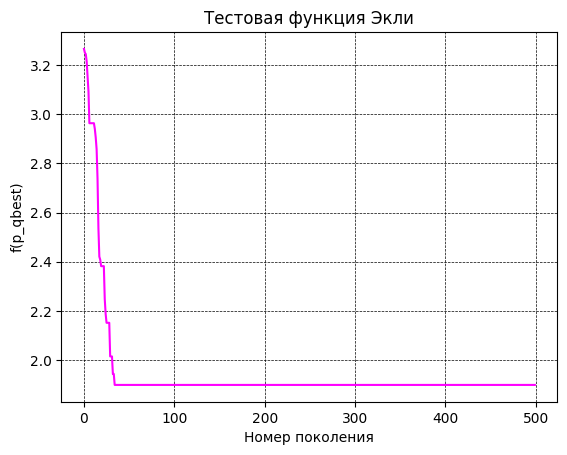

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.00247129 0.00468311]
The function value of pqbest:		0.015723457714265976
Algorithm running time:			0.062463998794555664 s


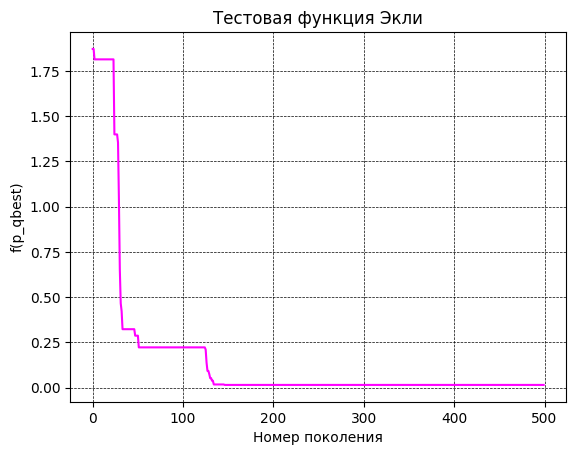

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.00188664 -0.01083105]
The function value of pqbest:		0.03431158617665275
Algorithm running time:			0.048407554626464844 s


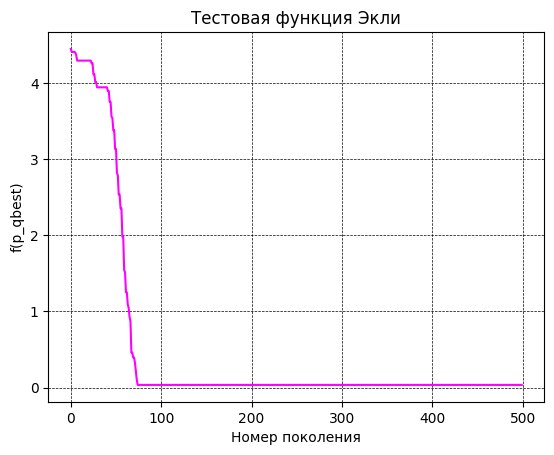

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.95190695 0.02466131]
The function value of pqbest:		2.5965902724654732
Algorithm running time:			0.06540632247924805 s


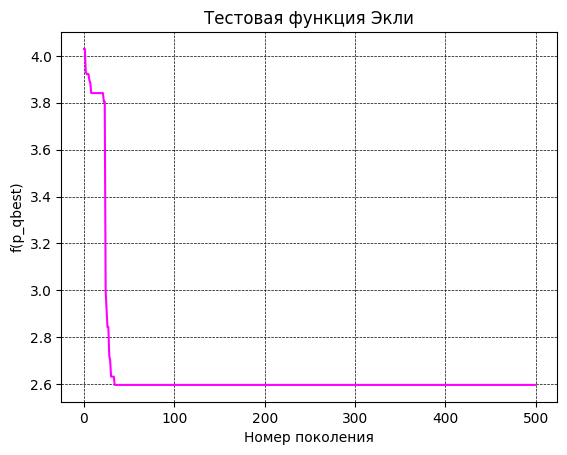

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.12941436 -0.20919772]
The function value of pqbest:		1.8014577514993206
Algorithm running time:			0.04685330390930176 s


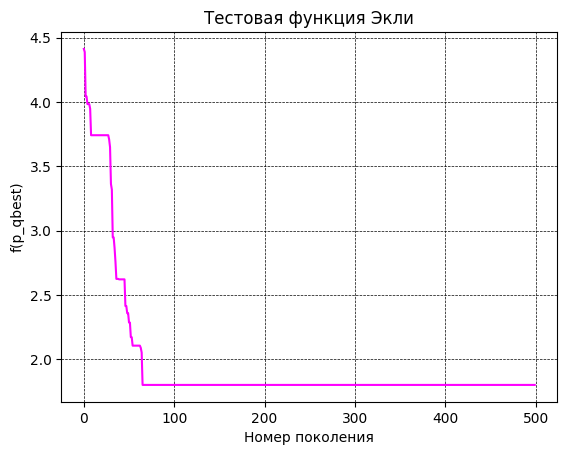

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.12010172  0.12172396]
The function value of pqbest:		1.1313682583289122
Algorithm running time:			0.062497854232788086 s


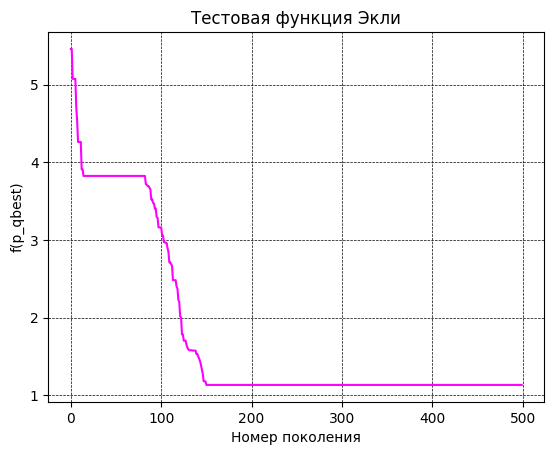

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.9360197  -0.01024247]
The function value of pqbest:		2.5887798307523724
Algorithm running time:			0.047821998596191406 s


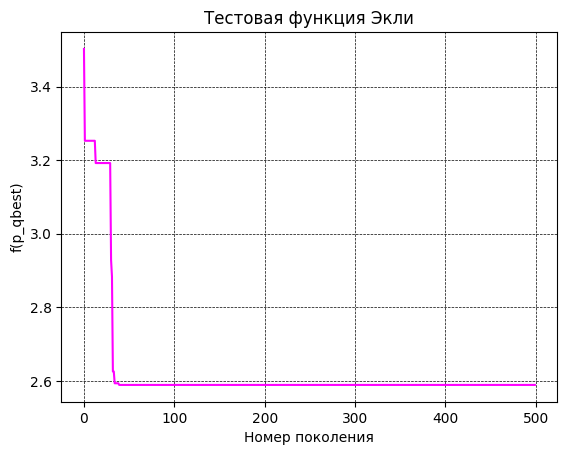

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.14008156 -0.08261344]
The function value of pqbest:		1.0503885097129029
Algorithm running time:			0.04685497283935547 s


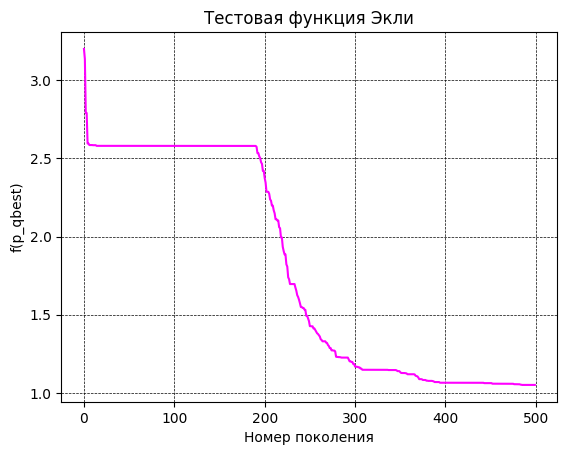

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.08861084 -0.11688061]
The function value of pqbest:		0.913073475695537
Algorithm running time:			0.048149824142456055 s


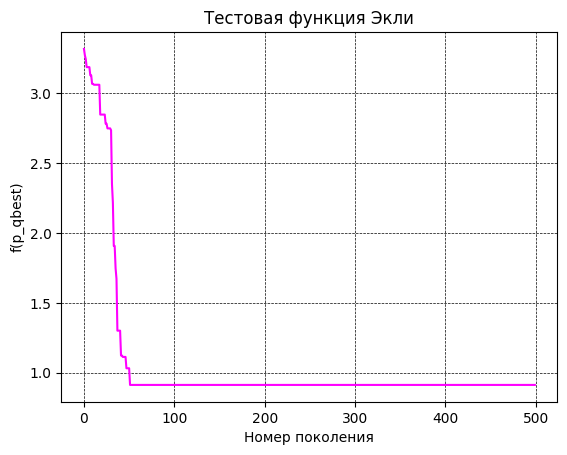

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.04528108 0.92455911]
The function value of pqbest:		2.6510373777795415
Algorithm running time:			0.05607128143310547 s


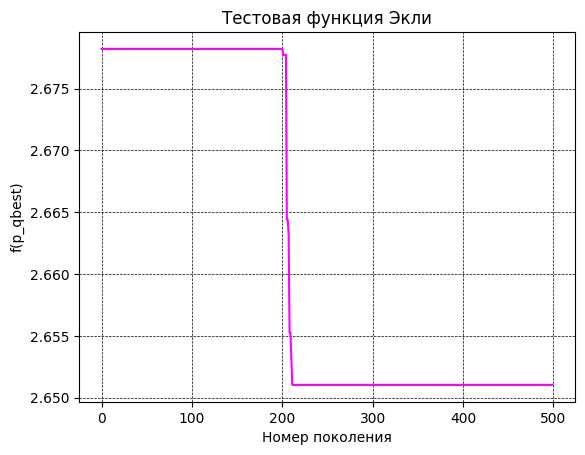

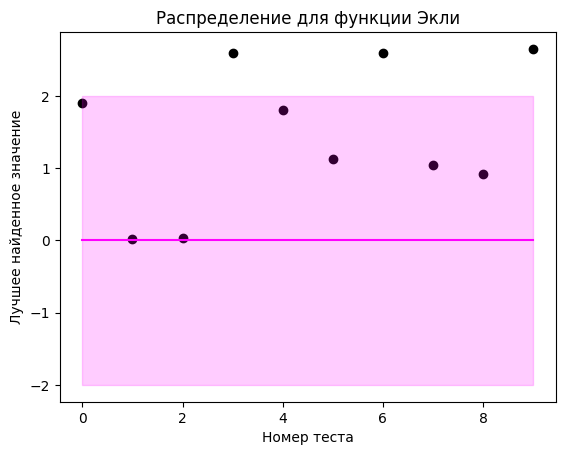

In [43]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [44]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [45]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-1, 1, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.00923079 -0.0029145 ]
The function value of pqbest:		9.370179657290154e-05
Algorithm running time:			3.150778293609619 s


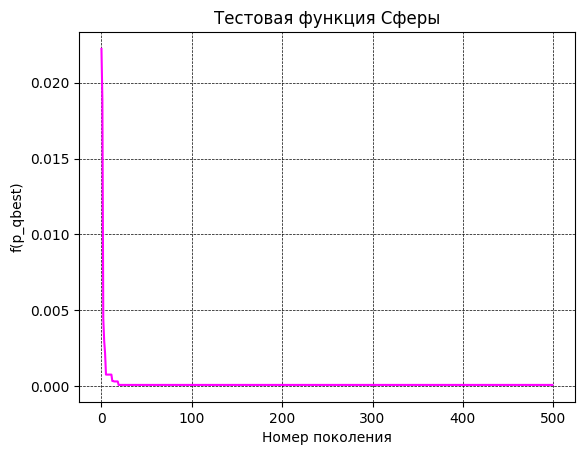

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.01787831 -0.03137769]
The function value of pqbest:		0.001304193308715161
Algorithm running time:			0.04685783386230469 s


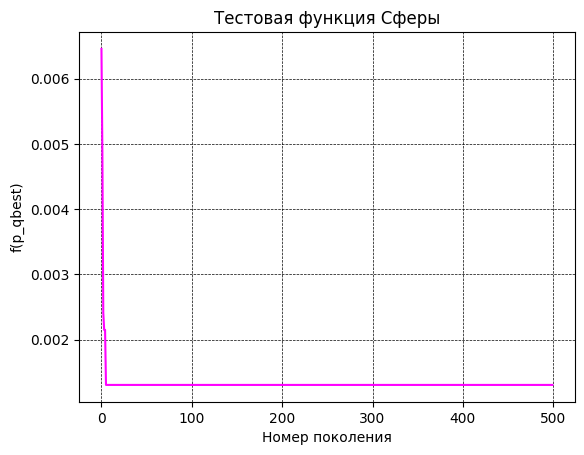

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.00777444  0.0060021 ]
The function value of pqbest:		9.64671710851312e-05
Algorithm running time:			0.031230688095092773 s


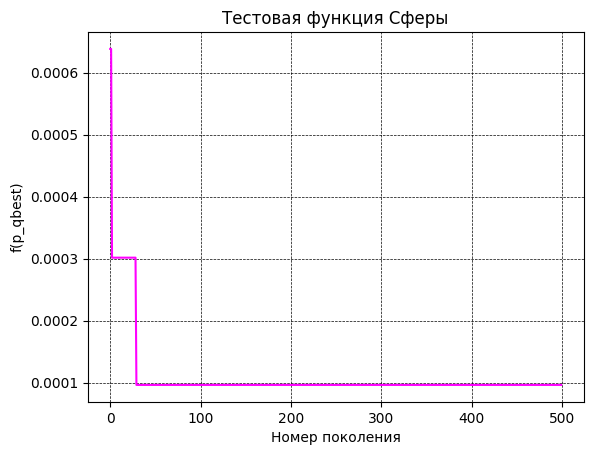

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.00343122 -0.00378836]
The function value of pqbest:		2.612490700721718e-05
Algorithm running time:			0.031235694885253906 s


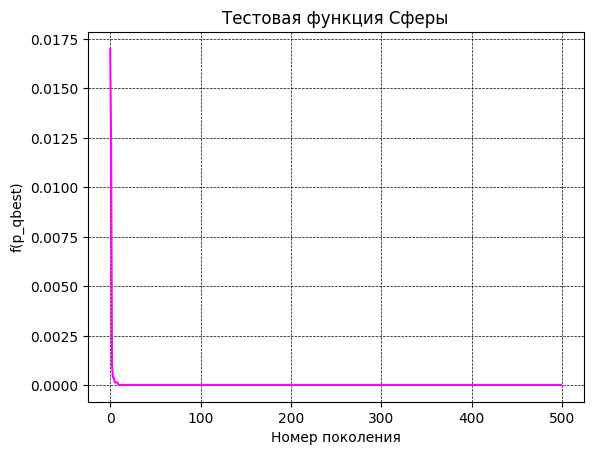

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.00344287 0.01590711]
The function value of pqbest:		0.000264889451761307
Algorithm running time:			0.0446169376373291 s


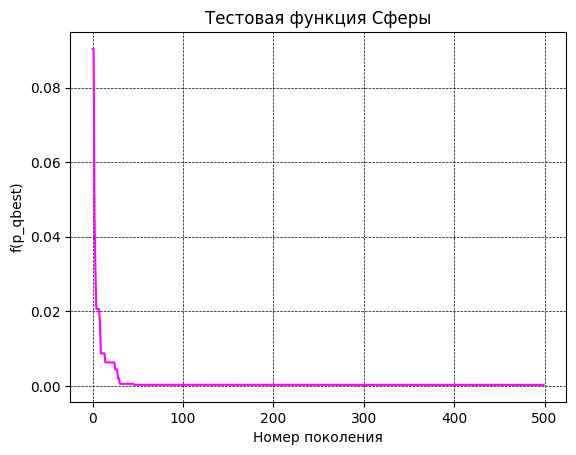

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.00640189 0.01174397]
The function value of pqbest:		0.00017890495885573526
Algorithm running time:			0.041530609130859375 s


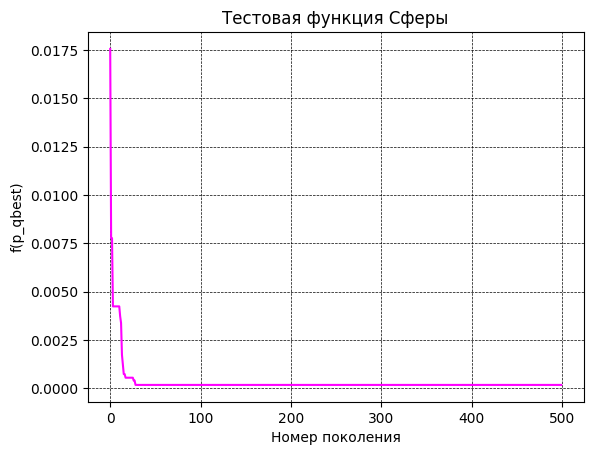

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.00743444 0.01041124]
The function value of pqbest:		0.00016366483525951875
Algorithm running time:			0.04687023162841797 s


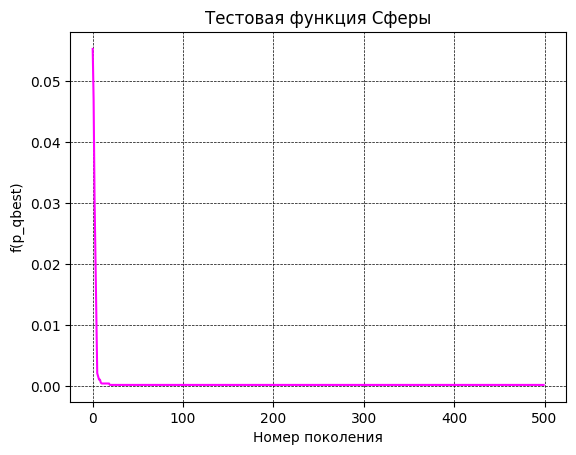

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.00145206  0.00606605]
The function value of pqbest:		3.890540972399711e-05
Algorithm running time:			0.04798293113708496 s


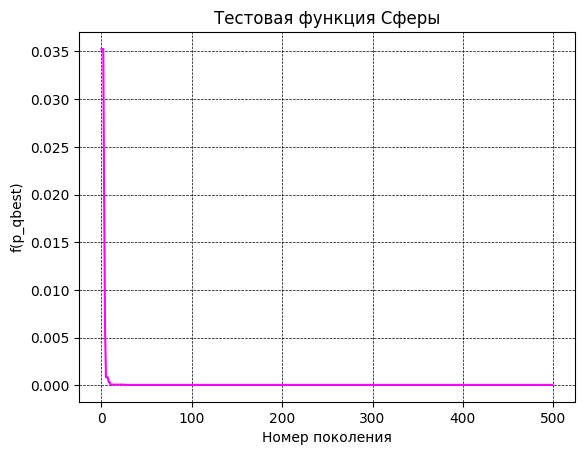

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.00054872 -0.00202097]
The function value of pqbest:		4.3854042700369815e-06
Algorithm running time:			0.04001212120056152 s


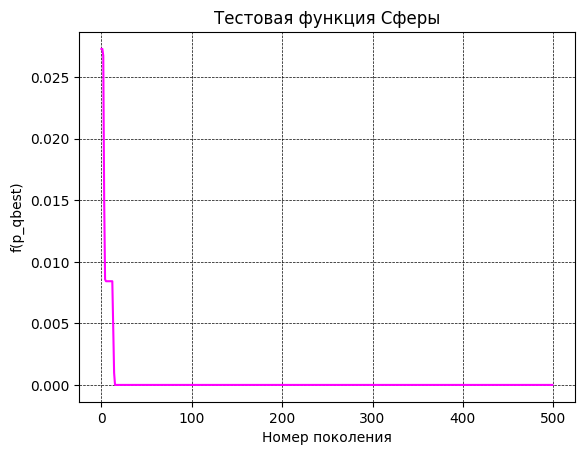

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.00011567 -0.00352307]
The function value of pqbest:		1.2425390448227439e-05
Algorithm running time:			0.04788565635681152 s


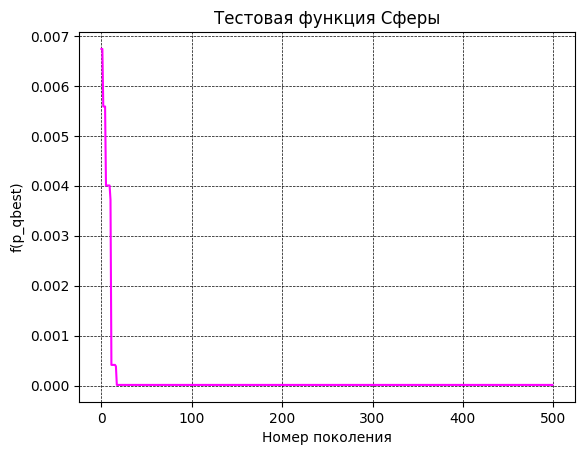

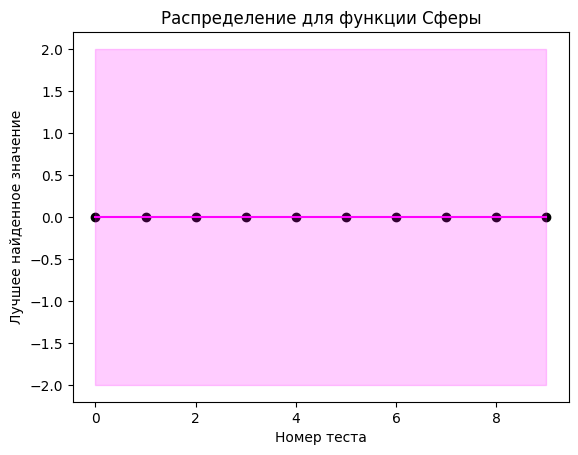

In [46]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [47]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [48]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[1.32880855 1.79496555]
The function value of pqbest:		0.19357413204652113
Algorithm running time:			3.588691473007202 s


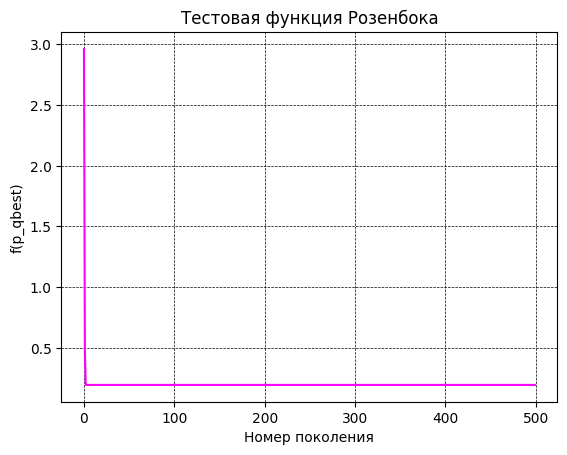

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[1.76210693 3.01491095]
The function value of pqbest:		1.392786413451857
Algorithm running time:			0.04687976837158203 s


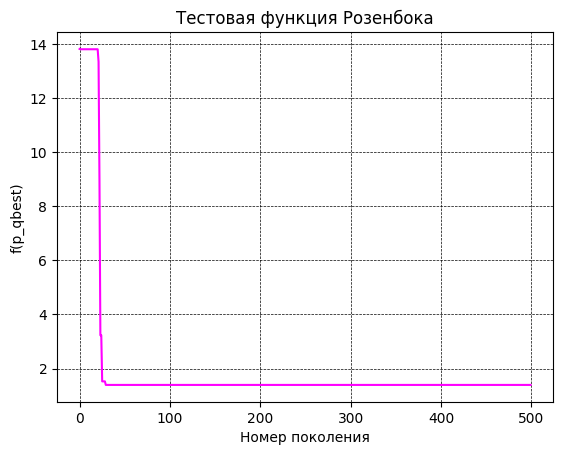

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.50921472  0.27875179]
The function value of pqbest:		2.3155677131510872
Algorithm running time:			0.041809797286987305 s


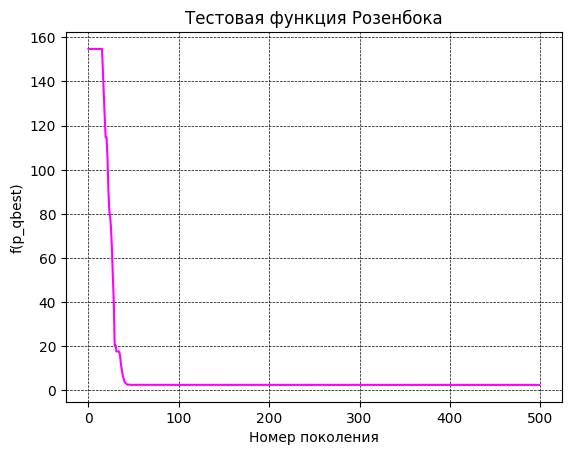

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2.27174851 5.17488078]
The function value of pqbest:		1.63705495585386
Algorithm running time:			0.038805246353149414 s


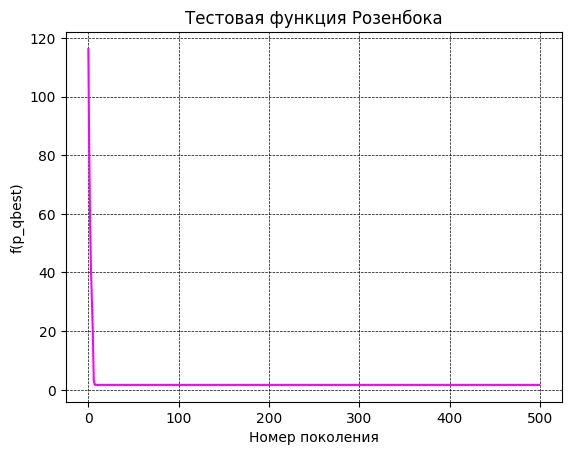

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[2.51716827 6.31997588]
The function value of pqbest:		2.3279149116003954
Algorithm running time:			0.04201960563659668 s


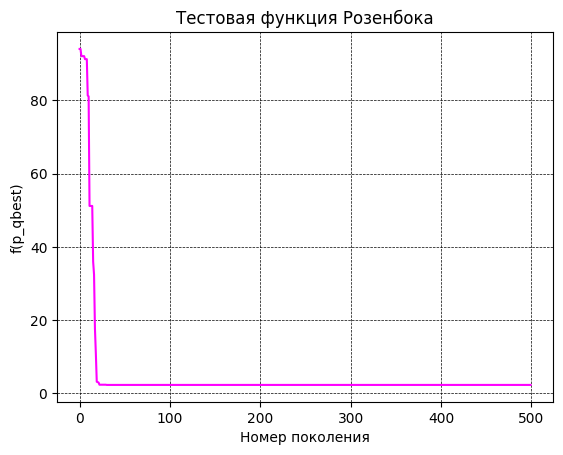

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.40311034 1.99424333]
The function value of pqbest:		0.22764907650268268
Algorithm running time:			0.04709887504577637 s


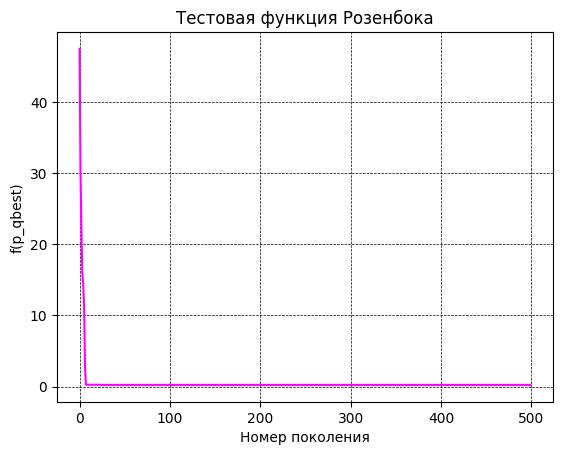

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.43884085 5.95681311]
The function value of pqbest:		2.078127897903493
Algorithm running time:			0.032266855239868164 s


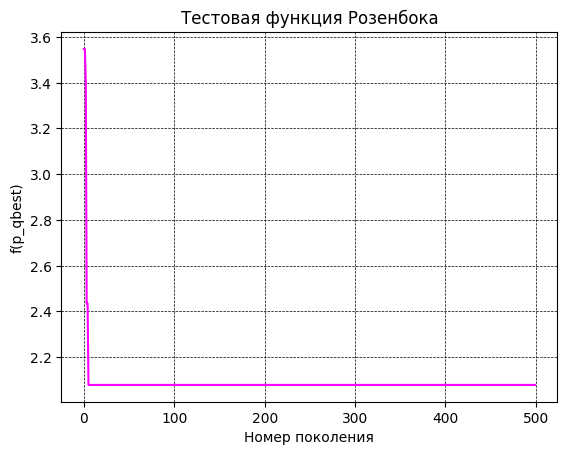

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[2.38565618 5.7178849 ]
The function value of pqbest:		1.9904244102464383
Algorithm running time:			0.04001593589782715 s


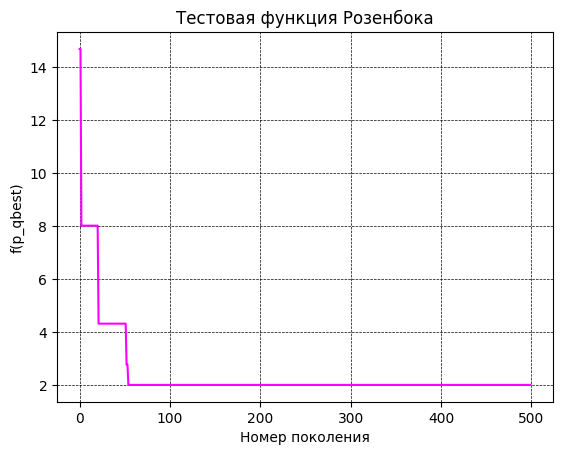

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.81772433 7.94905363]
The function value of pqbest:		3.3131148875158796
Algorithm running time:			0.03997993469238281 s


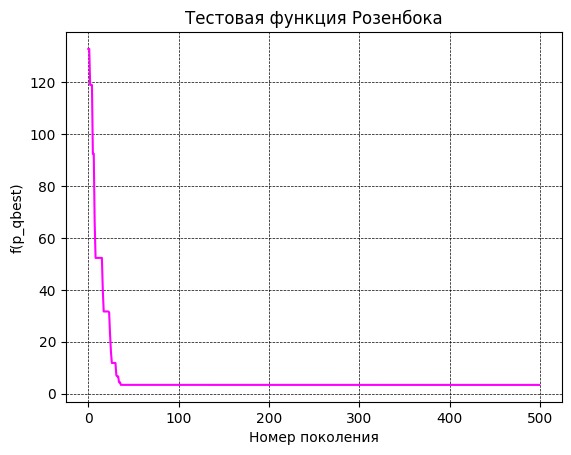

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[2.43884258 5.95014355]
The function value of pqbest:		2.0707477610543745
Algorithm running time:			0.031249046325683594 s


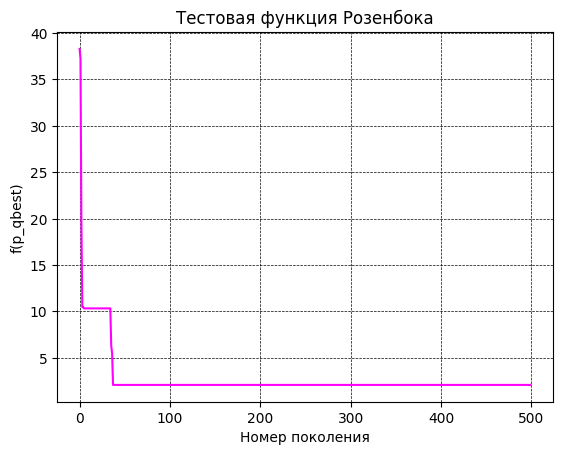

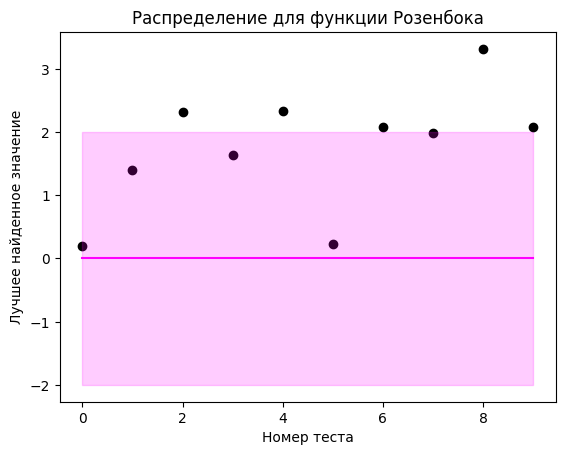

In [49]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [50]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [51]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[2.90828506 0.47619273]
The function value of pqbest:		0.001493974534218753
Algorithm running time:			3.3829612731933594 s


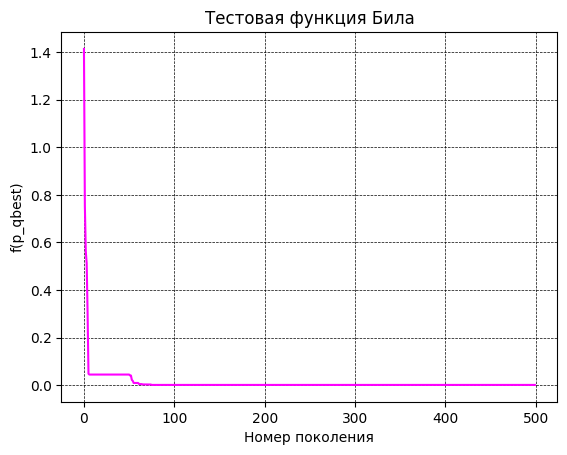

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[2.8275082  0.46803984]
The function value of pqbest:		0.009409521185454975
Algorithm running time:			0.03172564506530762 s


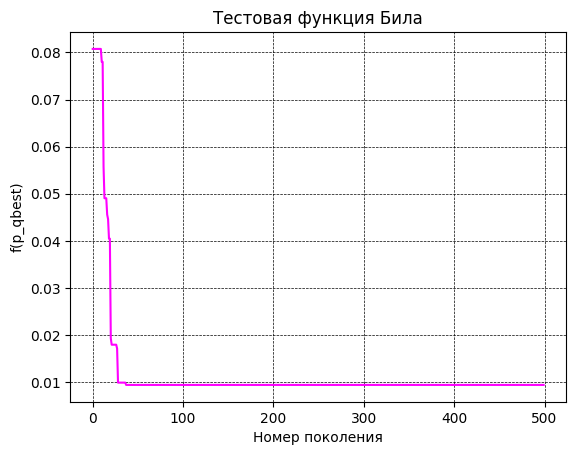

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[3.03185784 0.50913599]
The function value of pqbest:		0.00020015911427231824
Algorithm running time:			0.040006160736083984 s


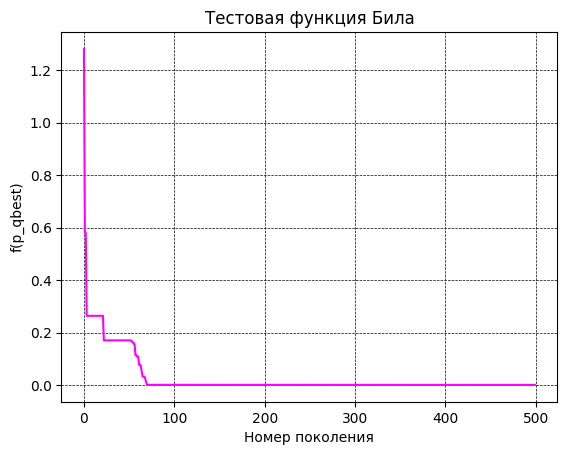

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2.96965003 0.48644017]
The function value of pqbest:		0.0009253075367854713
Algorithm running time:			0.03124237060546875 s


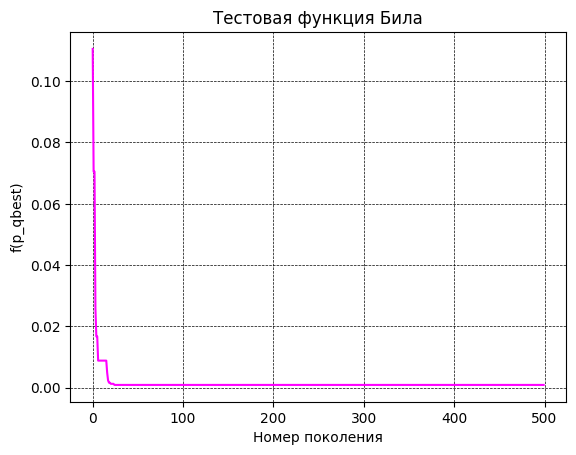

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[2.9693293  0.47955588]
The function value of pqbest:		0.003671977839436843
Algorithm running time:			0.039992332458496094 s


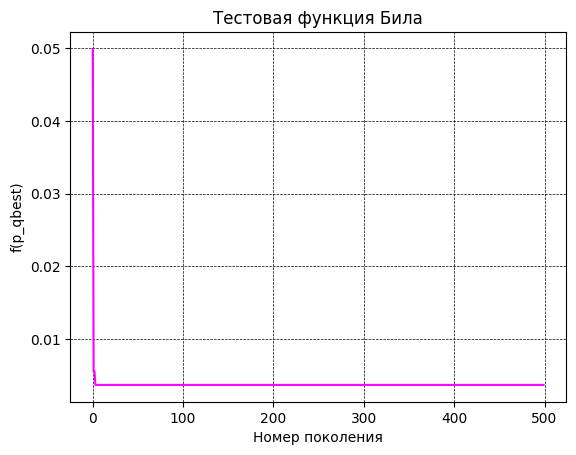

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[3.90167222 0.65027333]
The function value of pqbest:		0.05990239165068348
Algorithm running time:			0.04025769233703613 s


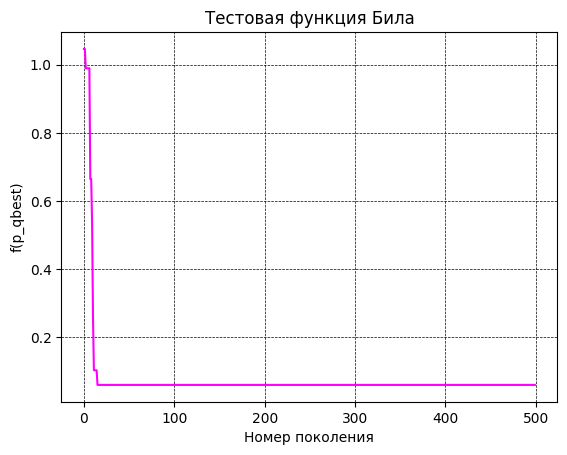

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.71594732 0.47780183]
The function value of pqbest:		0.0725753182613616
Algorithm running time:			0.046874284744262695 s


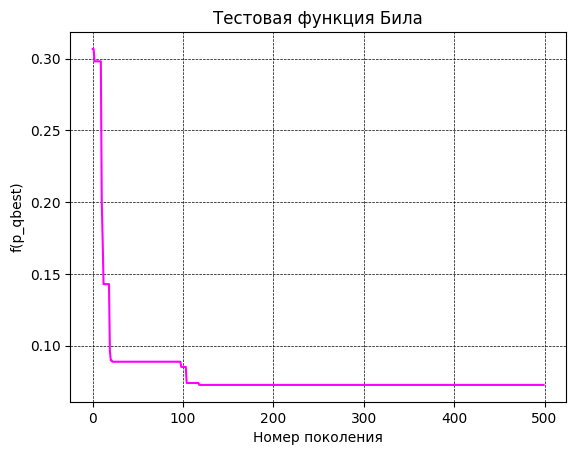

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[3.55258463 0.58950516]
The function value of pqbest:		0.04627898323334631
Algorithm running time:			0.04009127616882324 s


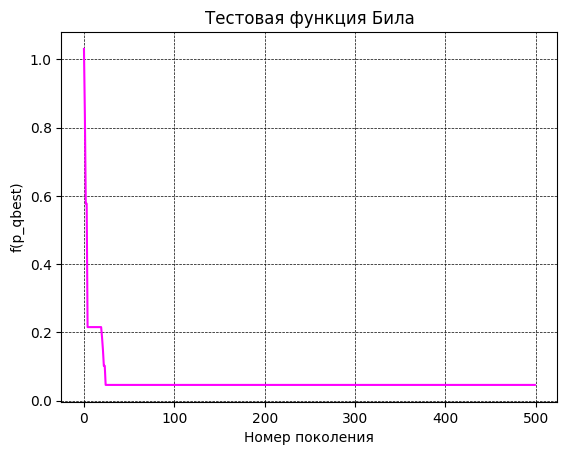

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[3.79972923 0.64191234]
The function value of pqbest:		0.048474038028155586
Algorithm running time:			0.031224727630615234 s


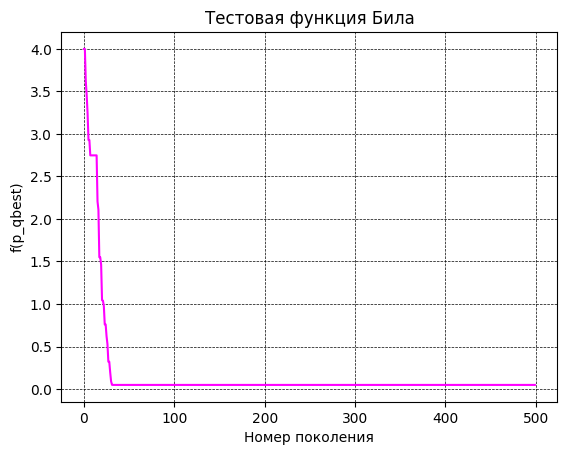

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[3.7684224  0.63705707]
The function value of pqbest:		0.046218482431834504
Algorithm running time:			0.039972782135009766 s


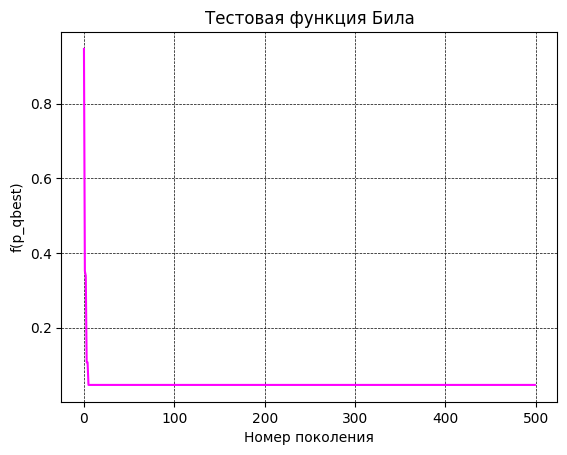

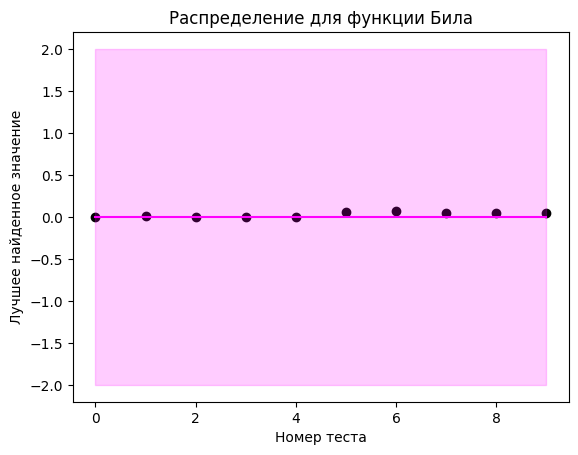

In [52]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [53]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [54]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.02785857 -0.98775516]
The function value of pqbest:		3.1836996274114773
Algorithm running time:			3.6389498710632324 s


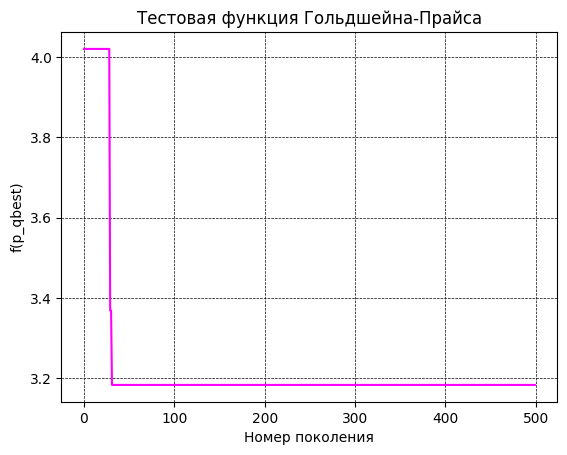

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.00455344 -1.00605799]
The function value of pqbest:		3.015219578275667
Algorithm running time:			0.04077863693237305 s


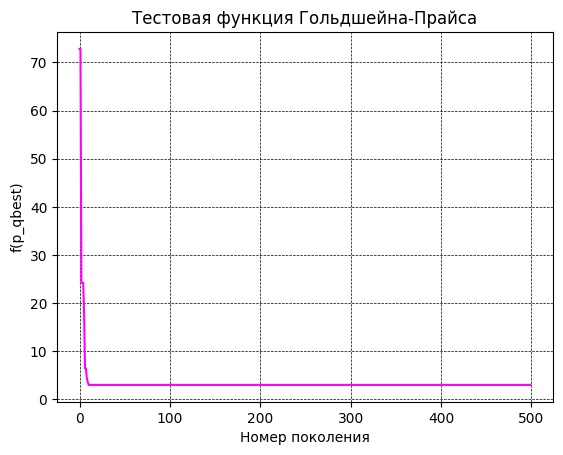

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.00281743 -1.00050078]
The function value of pqbest:		3.0024203336172035
Algorithm running time:			0.04703497886657715 s


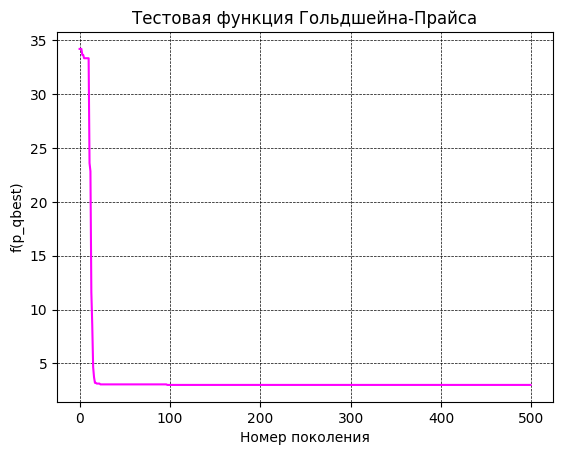

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.0081155  -0.98995562]
The function value of pqbest:		3.0422432658174836
Algorithm running time:			0.046854496002197266 s


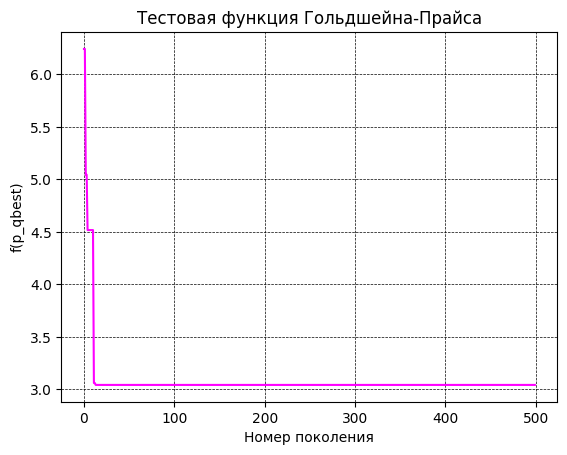

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.13489824 -0.94361585]
The function value of pqbest:		7.384265319225705
Algorithm running time:			0.03629350662231445 s


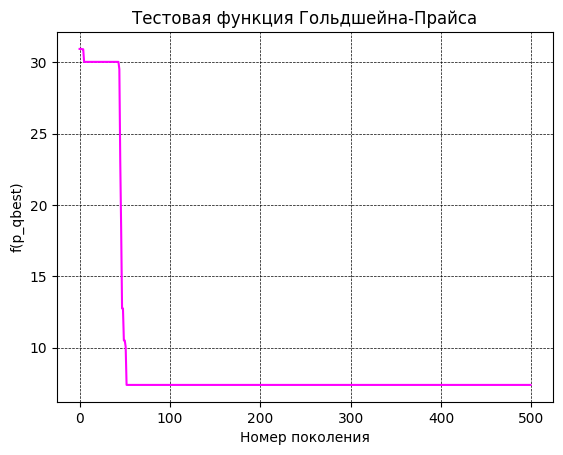

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.01810493 -1.00357382]
The function value of pqbest:		3.104608085800177
Algorithm running time:			0.041417598724365234 s


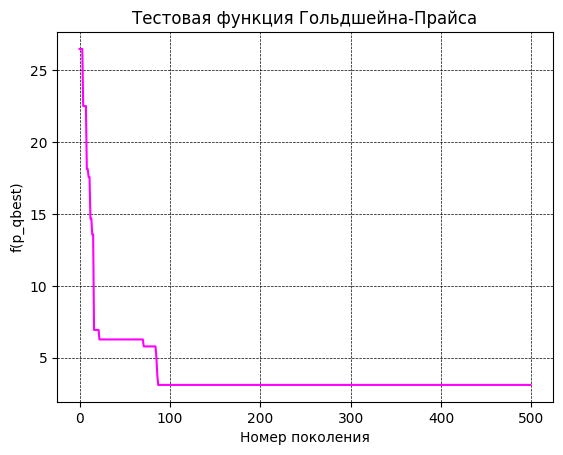

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.16364906 -0.90584434]
The function value of pqbest:		9.416911871120805
Algorithm running time:			0.039336204528808594 s


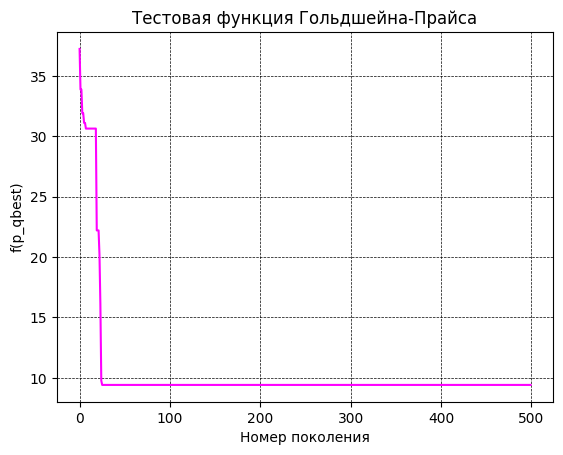

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.05444825 -0.99956725]
The function value of pqbest:		3.7799228430128613
Algorithm running time:			0.039995670318603516 s


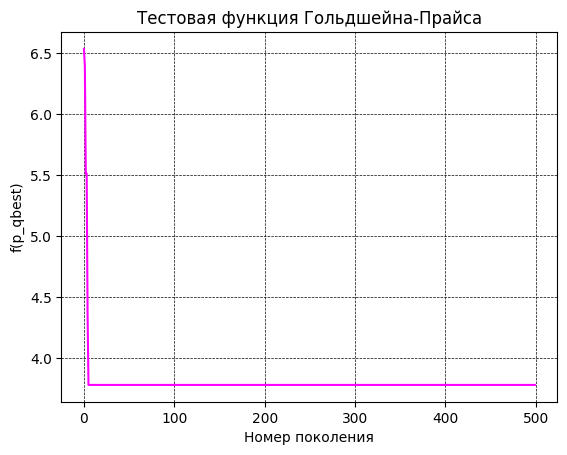

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.00178821 -0.99387115]
The function value of pqbest:		3.0145887130135756
Algorithm running time:			0.03997015953063965 s


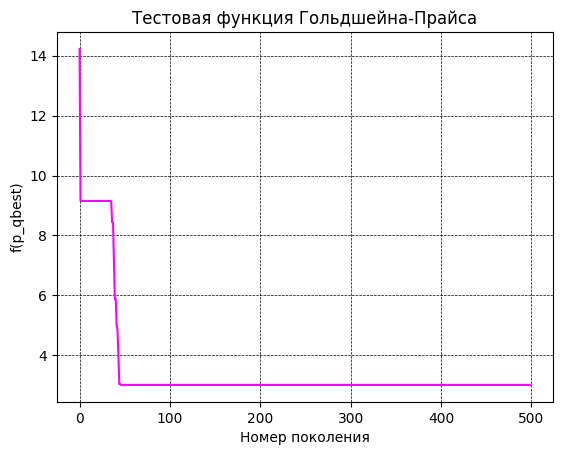

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.01675284 -0.97587514]
The function value of pqbest:		3.2327435231443093
Algorithm running time:			0.03997993469238281 s


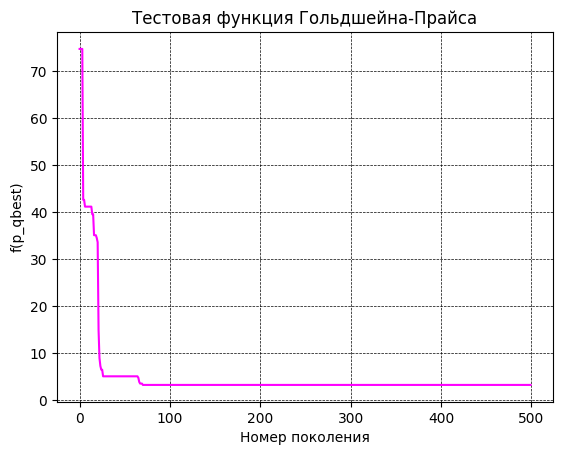

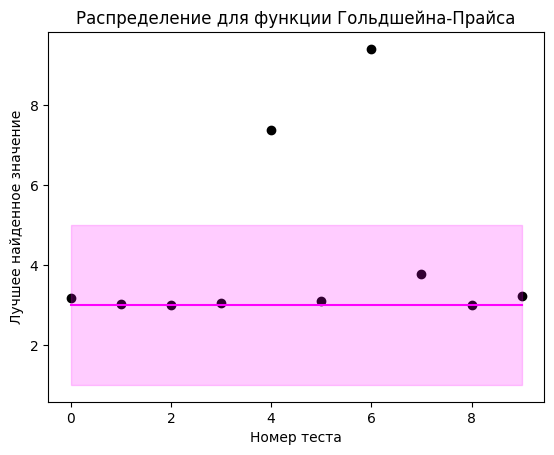

In [55]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3)

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [56]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [57]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.96044986 3.57152914]
The function value of pqbest:		0.26193267107366225
Algorithm running time:			3.482875347137451 s


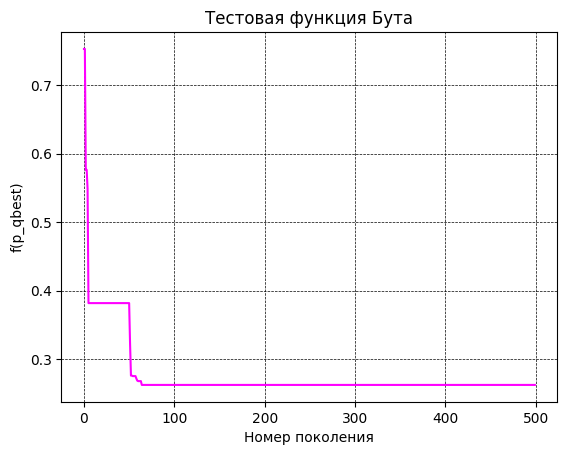

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[1.31286308 2.63649187]
The function value of pqbest:		0.07473270848966153
Algorithm running time:			0.04001116752624512 s


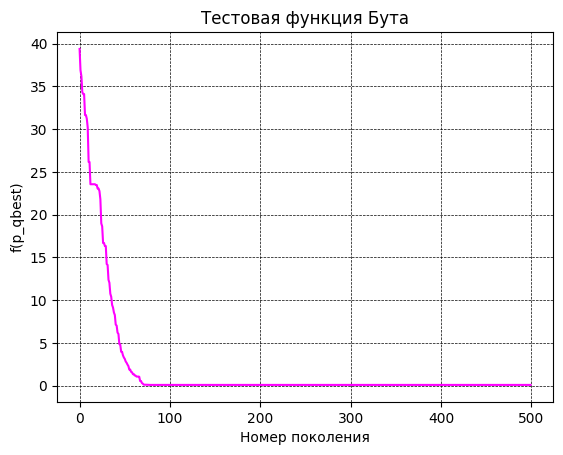

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.31795511 2.61639605]
The function value of pqbest:		0.0743530979979129
Algorithm running time:			0.031243324279785156 s


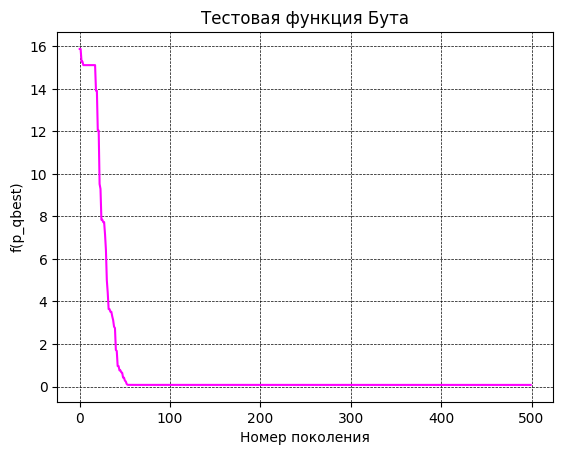

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[1.05042217 3.27667558]
The function value of pqbest:		0.1560271348063192
Algorithm running time:			0.031253814697265625 s


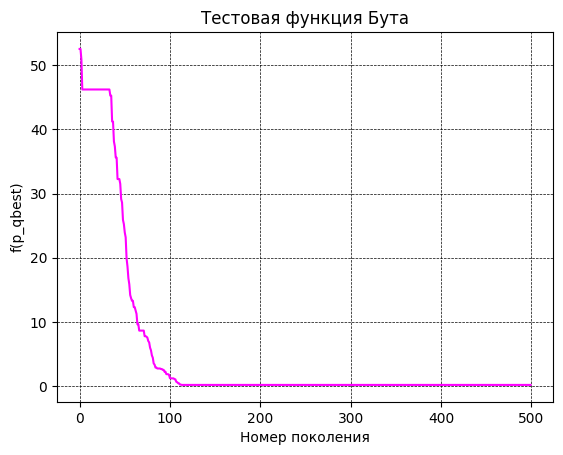

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.36706714 2.52448449]
The function value of pqbest:		0.07643294797440678
Algorithm running time:			0.031255483627319336 s


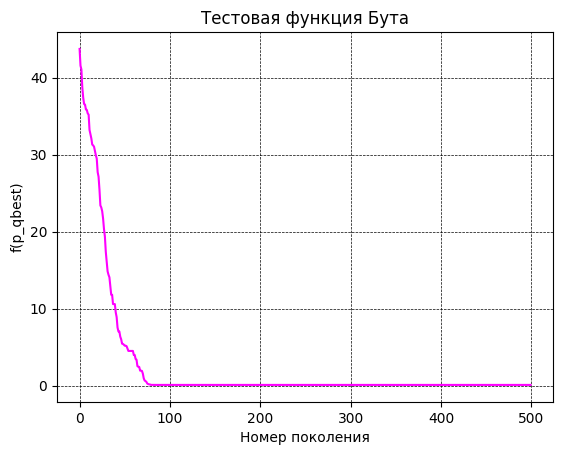

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.27749041 2.71427649]
The function value of pqbest:		0.07673433572431698
Algorithm running time:			0.0468754768371582 s


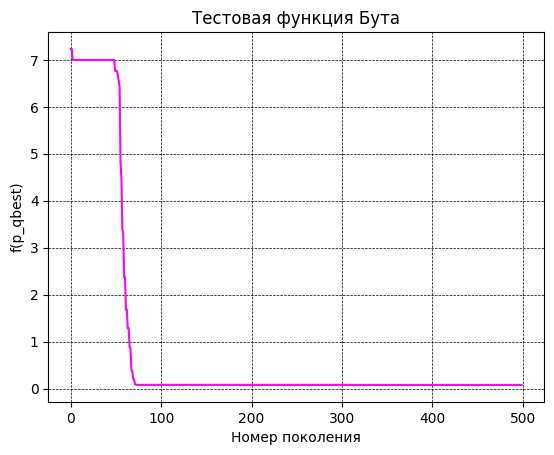

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.70089195 4.83721133]
The function value of pqbest:		1.5831907115322403
Algorithm running time:			0.03194594383239746 s


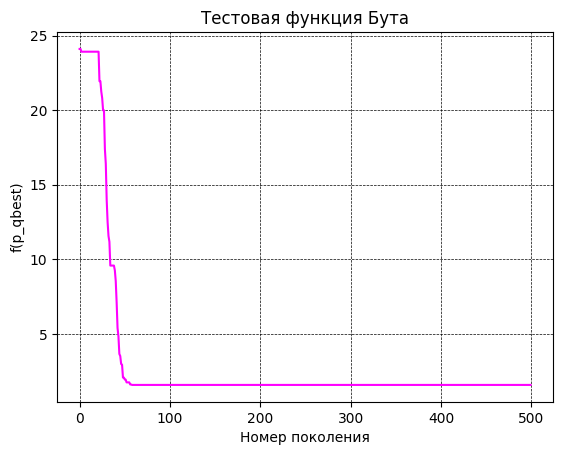

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[1.66716473 2.06775649]
The function value of pqbest:		0.17278619722638955
Algorithm running time:			0.031235694885253906 s


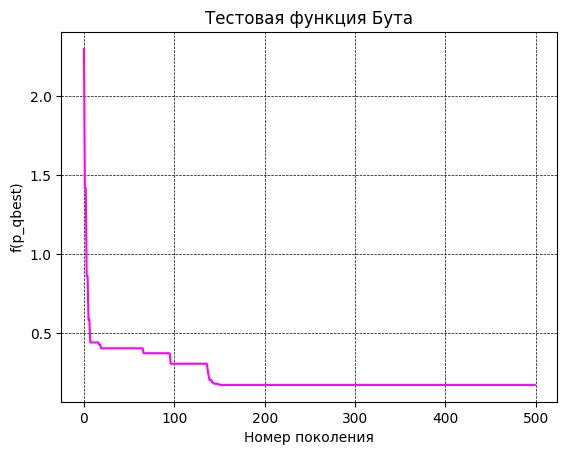

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.28956283 2.75733978]
The function value of pqbest:		0.12564698465132706
Algorithm running time:			0.04687047004699707 s


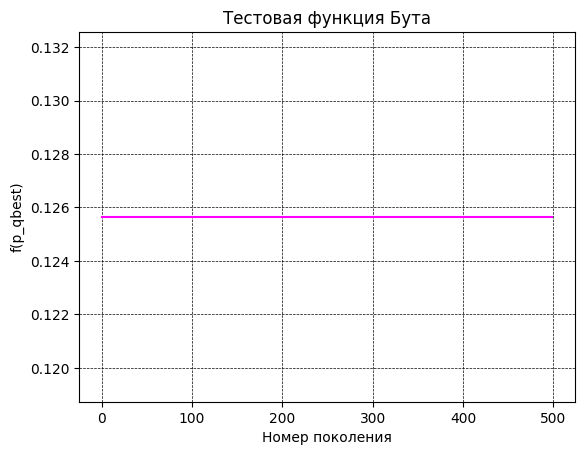

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[2.0105381  1.70660957]
The function value of pqbest:		0.5484583894170667
Algorithm running time:			0.031443119049072266 s


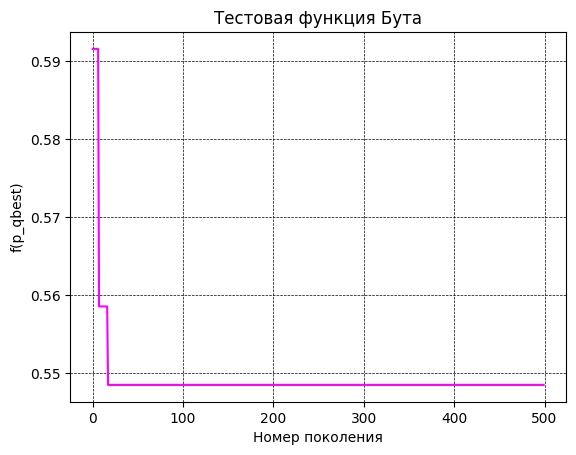

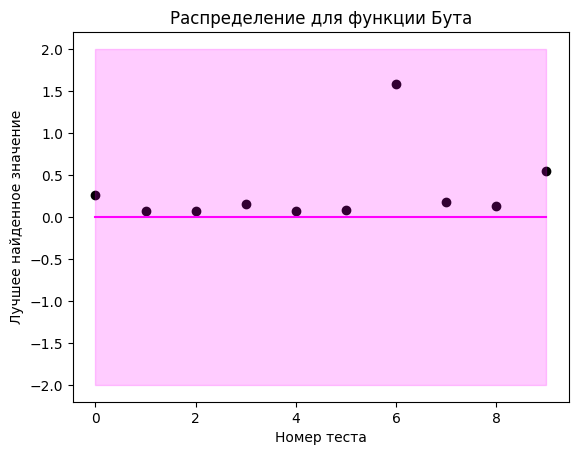

In [58]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_)

## Реализация алгоритма на C. Сравнение двух реализаций

In [59]:
import ctypes
import os


class Result(ctypes.Structure):
    _fields_ = [
        ("best_solution", ctypes.POINTER(ctypes.c_float)),
        ("best_y", ctypes.c_float),
        ("time_spent", ctypes.c_double)
    ]


def c(file, name, types, result):
    path = os.path.abspath(file)
    module = ctypes.cdll.LoadLibrary(path)
    func = module[name]
    func.argtypes = types
    func.restype = result
    return func


test_Rastrigen = c("libcode.dll", "test_Rastrigen", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Ekli = c("libcode.dll", "test_Ekli", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Sphere = c("libcode.dll", "test_Sphere", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Rosenbock = c("libcode.dll", "test_Rosenbock", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Bila = c("libcode.dll", "test_Bila", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Goldsheina_Praisa = c("libcode.dll", "test_Goldsheina_Praisa", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Buta = c("libcode.dll", "test_Buta", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)


## Сравнение реализаций по скорости выполнения

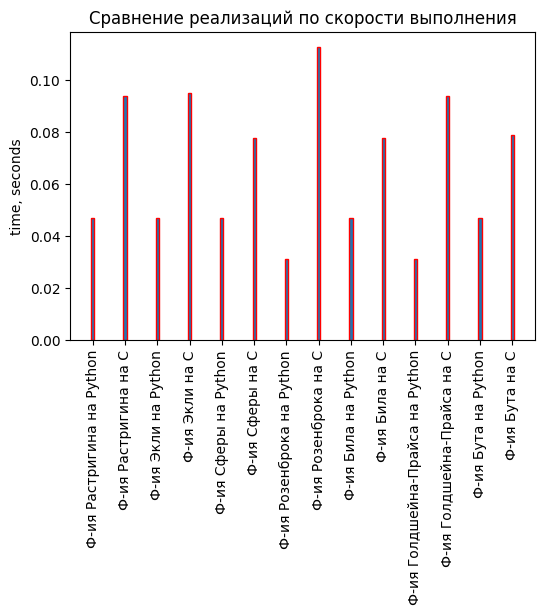

In [60]:
time_on_c = list()
time_on_c.append(test_Rastrigen(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Ekli(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Sphere(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Rosenbock(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Bila(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Goldsheina_Praisa(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Buta(number_of_agents_, n_args_count_, iter_max_).time_spent)

time_on_python = list()
start = time.time()
main_function(f1, generate_agents1, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f2, generate_agents2, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f3, generate_agents3, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f4, generate_agents4, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f5, generate_agents5, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f6, generate_agents6, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f7, generate_agents7, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)

plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

list_to_draw = list()
for i in range(7):
    list_to_draw.append(time_on_python[i])
    list_to_draw.append(time_on_c[i])

list_of_title = ['Ф-ия Растригина на Python', 'Ф-ия Растригина на C',
                 'Ф-ия Экли на Python', 'Ф-ия Экли на C',
                 'Ф-ия Сферы на Python', 'Ф-ия Сферы на C',
                 'Ф-ия Розенброка на Python', 'Ф-ия Розенброка на С',
                 'Ф-ия Била на Python', 'Ф-ия Била на C',
                 'Ф-ия Голдшейна-Прайса на Python', 'Ф-ия Голдшейна-Прайса на C',
                 'Ф-ия Бута на Python', 'Ф-ия Бута на C']

ax.bar(list_of_title, list_to_draw, width=0.1, edgecolor='r')

plt.ylabel("time, seconds")
plt.title("Сравнение реализаций по скорости выполнения")
plt.xticks(rotation=90)
plt.show()

## Тестирование алгоритма в n-мерном пространстве

### Тестирование алгоритма в 100-мерном пространстве

In [62]:
start = time.time()
res = main_function(f3, generate_agents3, 100, iter_max_, number_of_agents_, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 26.974706102035853
Time is 0.16517329216003418
Coordinates: [ 0.60193074 -0.82065355  0.4249204  -0.81515764  0.22825129  0.91162377
 -0.13637135 -0.04362856  0.8256582   0.11525717 -0.5045826  -0.49628747
  0.8932519   0.10599319  0.600451   -0.8821094   0.81658967  0.14870572
 -0.4799275  -0.5424139   0.74015432 -0.65112005  0.18333334 -0.75287999
 -0.59200458  0.33388571  0.97716521  0.07855128  0.57568572 -0.18865369
  0.0173202  -0.49266086  0.69922633 -0.53906272  0.16245173 -0.62086685
  0.26828946  0.59605097  0.33189347  0.3749091  -0.62669402  0.40404664
 -0.44898712  0.03286612  0.03840771  0.51048338  0.18820108 -0.49505098
 -0.04117294  0.04341487 -0.24660881  0.13676659 -0.75451493  0.31523806
  0.32352505 -0.04081807 -0.88564616 -0.51751013  0.90624889  0.27177883
 -0.07482363  0.1161891  -0.41742335 -0.94760127  0.56764845 -0.20744334
  0.087502   -0.41746151 -0.32516158  0.79550873  0.41438516  0.01575769
 -0.0636557

### Тестирование алгоритма в 50-мерном пространстве

In [63]:
start = time.time()
res = main_function(f3, generate_agents3, 50, iter_max_, number_of_agents_, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 5.610794806582598
Time is 0.13620424270629883
Coordinates: [ 0.21610953  0.39850298  0.29273754  0.33832357  0.12299683  0.16378613
  0.53229206  0.42649744  0.31464143  0.31059851  0.50675808  0.3209813
  0.3628057   0.28312033  0.29976448  0.22010284  0.09394132  0.15869969
  0.17201619  0.41055021  0.51437496  0.37412655  0.42306767 -0.01185615
  0.44921261  0.43743311  0.34577881  0.14276249  0.45043568  0.22706955
  0.36328853  0.39786794  0.33173398 -0.02529765  0.24966144  0.22570125
  0.33592704  0.09197319  0.23888899  0.47260968  0.39212068  0.35557271
  0.28981328  0.14325702  0.52788513  0.48221807  0.24093302  0.24722513
  0.45574632  0.22457432]


### Тестирование алгоритма в 10-мерном пространстве

In [64]:
start = time.time()
res = main_function(f3, generate_agents3, 10, iter_max_, number_of_agents_, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 0.7144366169945643
Time is 0.10052728652954102
Coordinates: [ 0.63069621 -0.02291214 -0.17582501 -0.21302832 -0.1274233   0.17640626
  0.13987975 -0.33290816  0.2121533   0.13068805]
